In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from google.colab import files
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
#loading the files
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
variables = pd.read_csv('VariableDefinitions.csv')

In [3]:
#checking on the shape of the train & test dataset
train.shape, test.shape

((23524, 13), (10086, 12))

In [4]:
#inspecting the train dataset
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [5]:
#inspecting the test dataset
test.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [6]:
#checking on the missing values
train.isnull().sum()

,0
country,0
year,0
uniqueid,0
bank_account,0
location_type,0
cellphone_access,0
household_size,0
age_of_respondent,0
gender_of_respondent,0
relationship_with_head,0


The train data set has no missing values

In [7]:
#checking on the duplicates
train.duplicated().sum()

0

the data has no duplicates

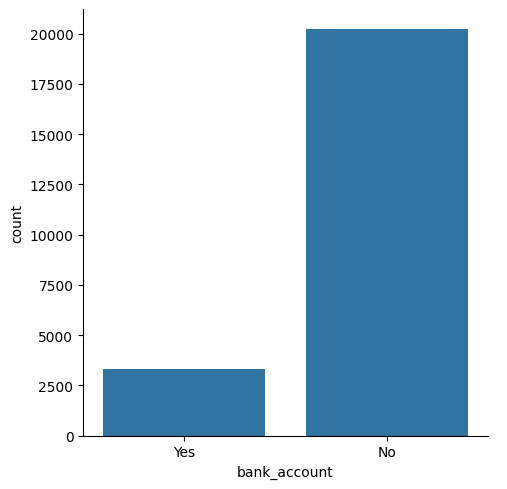

In [8]:
#visualizing the target distribution
sns.catplot(x="bank_account", kind="count", data=train)

## 2. Understand the dataset
We can get more information about the features presented by using the info() method from pandas.

In [9]:
#checking the info of the dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


##Data preparation for machine learning
I perform data cleaning and preprocessing. This is a very important step; your model will not perform well without these steps.

The first step is to separate the independent variables and target(bank_account) from the train data. Then transform the target values from the object data type into numerical by using LabelEncoder.

In [10]:
#label encoding
le = LabelEncoder()
train['bank_account'] = le.fit_transform(train['bank_account'])
#Separate training features from target
X = train.drop('bank_account', axis=1)
y = train['bank_account']
print(y)

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 23524, dtype: int64


In [11]:
# function to preprocess our data from train models
def preprocessing_data(data):

    # Convert the following numerical labels from interger to float
    float_array = data[["household_size", "age_of_respondent", "year"]].values.astype(float)

    # categorical features to be onverted to One Hot Encoding
    categ = ["relationship_with_head",
             "marital_status",
             "education_level",
             "job_type",
             "country"]

    # One Hot Encoding conversion
    data = pd.get_dummies(data, prefix_sep="_", columns=categ)

    # Label Encoder conversion
    data["location_type"] = le.fit_transform(data["location_type"])
    data["cellphone_access"] = le.fit_transform(data["cellphone_access"])
    data["gender_of_respondent"] = le.fit_transform(data["gender_of_respondent"])

    # drop uniquid column
    data = data.drop(["uniqueid"], axis=1)

    # scale our data into range of 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    return data

In [12]:
from sklearn.preprocessing import MinMaxScaler
# preprocess the train data
processed_train = preprocessing_data(X)
processed_test = preprocessing_data(test)


In [13]:
#checking on the first row in train
processed_train[0]

array([1.       , 0.       , 1.       , 0.1      , 0.0952381, 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 1.       ,
       0.       , 0.       , 1.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 1.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 1.       , 1.       , 0.       , 0.       ,
       0.       ])

In [14]:
#shape of the train
processed_train.shape

(23524, 37)

#Modeling

In [15]:
import sklearn.model_selection
#spliting the train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processed_train, y, test_size=0.1, random_state=42)

I will use 10% of the train dataset to evaluate the models. . The parameter stratify = y_train will ensure an equal balance of values from both classes (‘yes’ and ‘no’) for both train and validation set.

In [16]:
#Random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)


0.8589035274118147

In [17]:
#evaluate the prediction
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2028
           1       0.49      0.38      0.42       325

    accuracy                           0.86      2353
   macro avg       0.69      0.66      0.67      2353
weighted avg       0.85      0.86      0.85      2353




Precision measures the proportion of correctly predicted positives out of all predicted positives, while recall (sensitivity) measures the proportion of actual positives correctly identified. The F1-score is the harmonic mean of precision and recall, balancing both metrics. "Support" indicates the number of true instances for each class (0 or 1). Here, class 0 has high metrics due to more samples, while class 1 shows lower performance. Overall accuracy is 86%, with macro and weighted averages reflecting class imbalances.

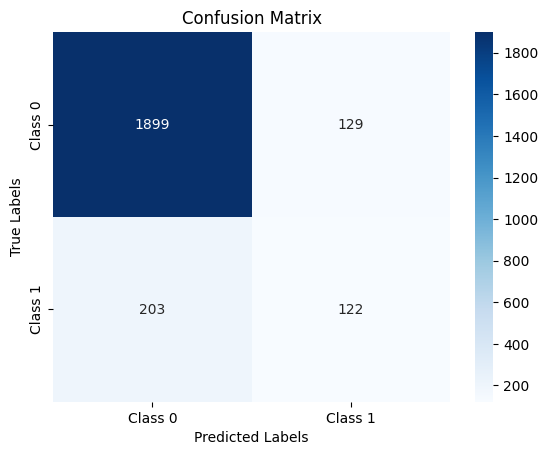

In [18]:
#checking the confusion matrix of the random classifier
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)
#drawing the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Subset the training data (optional: remove if full dataset should be used)
X_train_sample = X_train[:1000]  # Use a subset if dataset is large
y_train_sample = y_train[:1000]

# Define the Random Forest Classifier and parameter distribution
rf = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# RandomizedSearchCV for efficient hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,          # Number of parameter combinations to try
    cv=5,               # 5-fold cross-validation
    n_jobs=-1,          # Use all available processors
    random_state=42
)

# Fit the model
random_search.fit(X_train_sample, y_train_sample)

# Get the best parameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_

# Display the results
print("Best parameters:", best_params)
print("Best score:", best_score)



Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}
Best score: 0.8870000000000001


The optimal Random Forest configuration uses 200 estimators, a minimum samples split of 5, and a maximum depth of 20. This setup achieved a best cross-validation accuracy score of 88.1%, indicating a well-tuned model performance.

First Submission

In [22]:
# Get the predicted result for the test Data
# Fit the RandomForestClassifier model on the training data
rf.fit(X_train, y_train)
y_pred = rf.predict(processed_test)


In [26]:
# Create submission DataFrame
submission = pd.DataFrame({
    "uniqueid": test["uniqueid"] + " x " + test["country"],
    "bank_account": y_pred
})

# Save the submission file as a CSV
submission_file_path = "submission.csv"
submission.to_csv(submission_file_path, index=False)

# Provide download link for the generated file
print(f"Submission file saved as {submission_file_path}.")


Submission file saved as submission.csv.


In [27]:
from google.colab import files
files.download(submission_file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>